## Deploy Models On Azure
    (1) Retrieve the train model
    (2) Test the model locally
    (3) Evaluate the model
    (4) Create unit tests    
    (5) Deploy as a web service
    (6) Test the deployed service
    (7) Enable app-insights
    (8) TODO: Build a CI/CD pipeline to train, evaluate and deploy model using Azure Pipelines

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
 
import azureml
from azureml.core import Workspace, Run

# Display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.3.0


### (1) Retrieve the train model

In [2]:
# https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-deploy-models-with-aml
from azureml.core import Workspace
from azureml.core.model import Model
import os
ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')

model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "sklearn_mnist_model.pkl")

os.stat(file_path)

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


os.stat_result(st_mode=33188, st_ino=1371208, st_dev=66306, st_nlink=1, st_uid=1000, st_gid=1000, st_size=63684, st_atime=1587541146, st_mtime=1587655644, st_ctime=1587655644)

### (2) Test the model locally

In [3]:
from utils import load_data
import os

data_folder = os.path.join(os.getcwd(), 'data_folder')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / 255.0
y_test = load_data(os.path.join(
    data_folder, 't10k-images-idx3-ubyte.gz'), True).reshape(-1)

In [4]:
import pickle
from sklearn.externals import joblib

clf = joblib.load(os.path.join(os.getcwd(), 'sklearn_mnist_model.pkl'))
y_hat = clf.predict(X_test)

### (3) Evaluate the model

In [5]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_hat)
print(confusion_mat)
print('Overall accuracy:', np.average(y_hat == y_test))

[[835 938 803 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 28  35  26 ...   0   0   0]
 [ 13  33  18 ...   0   0   0]
 [  1   2   2 ...   0   0   0]]
Overall accuracy: 0.0845


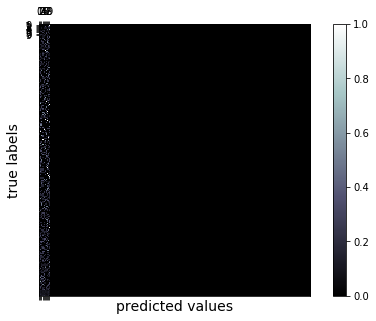

In [6]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = confusion_mat.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_mat / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

### (4) Create unit tests  

### (5) Deploy as a web service

In [10]:
# Create environment file
from azureml.core.conda_dependencies import CondaDependencies

env = CondaDependencies()
env.add_conda_package("scikit-learn==0.20.3")
env.add_pip_package("azureml-defaults")

with open("sklearn-mnist.yml", "w") as f:
    f.write(env.serialize_to_string())

# Read environment file
with open("sklearn-mnist.yml", "r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults
- scikit-learn==0.20.3
channels:
- anaconda
- conda-forge



In [11]:
# Create a deployment configuration
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  
                                                     "method": "sklearn"},
                                               description='Predict MNIST with sklearn')


In [13]:
#Service deployment
#%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment

env = Environment.from_conda_specification(name="sklearn-mnist-env", file_path="sklearn-mnist.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=env)

service = Model.deploy(workspace=ws,
                       name='sklearn-mnist-svc',
                       models=[model], 
                       inference_config=inference_config,
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Running...................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [14]:
# Get the scoring web service's HTTP endpoint,
print(service.scoring_uri)

http://1f68c433-1827-4f93-972d-5160f7d8c882.eastus.azurecontainer.io/score


### (6) Test the deployed service

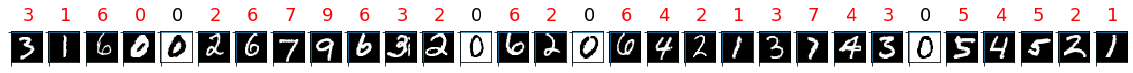

In [15]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

In [16]:
# send a raw HTTP request to test the web service

import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://1f68c433-1827-4f93-972d-5160f7d8c882.eastus.azurecontainer.io/score
label: 0
prediction: [2]
